In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
df = pd.read_csv(
    "../data/MachineLearningRating_v3.txt", delimiter="|",dtype={ "CapitalOutstanding": str,"CrossBorder": str},
    low_memory=False)

In [3]:
# Overview
print(df.shape)
df.isna().sum()

(1000098, 52)


UnderwrittenCoverID               0
PolicyID                          0
TransactionMonth                  0
IsVATRegistered                   0
Citizenship                       0
LegalType                         0
Title                             0
Language                          0
Bank                         145961
AccountType                   40232
MaritalStatus                  8259
Gender                         9536
Country                           0
Province                          0
PostalCode                        0
MainCrestaZone                    0
SubCrestaZone                     0
ItemType                          0
mmcode                          552
VehicleType                     552
RegistrationYear                  0
make                            552
Model                           552
Cylinders                       552
cubiccapacity                   552
kilowatts                       552
bodytype                        552
NumberOfDoors               

##  Missing Value Analysis and Strategy for Insurance Dataset

###  🔍 Key Observations on Missing Values

| Variable                        | Missing Count | Impact on Analysis                                     |
|--------------------------------|----------------|--------------------------------------------------------|
| `Bank`                         | 145,961        | Moderate; affects demographics but not premiums/claims |
| `AccountType`                  | 40,232         | Slight impact; may need imputation or exclusion        |
| `make`, `Model`, etc.          | ~552           | Very low %; can drop or impute easily                  |
| `CustomValueEstimate`          | 779,642        | Very high missingness — likely unusable                |
| `NewVehicle`, `WrittenOff`, `Rebuilt`, `Converted` | 150k–640k+ | Possibly safe to exclude unless critical              |
| `CrossBorder`                  | 999,400        | >99% missing — should be dropped                       |
| `NumberOfVehiclesInFleet`      | 1,000,098      | Fully missing — **drop column**                        |

---

## ✅ Recommended Actions

### 1. Drop Columns with Excessive Missingness

Drop the following columns:

```python
df = df.drop(columns=[
    'CrossBorder', 
    'NumberOfVehiclesInFleet', 
    'CustomValueEstimate',
    'WrittenOff', 
    'Rebuilt', 
    'Converted'
])

In [4]:
df = df.drop(columns=[
    'CrossBorder', 
    'NumberOfVehiclesInFleet', 
    'CustomValueEstimate',
    'WrittenOff', 
    'Rebuilt', 
    'Converted'
])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 46 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

## Data format modification

In [6]:
# Convert to datetime
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'], errors='coerce')
df['VehicleIntroDate'] = pd.to_datetime(df['VehicleIntroDate'], format='%m/%Y', errors='coerce')
df['CapitalOutstanding'] = pd.to_numeric(df['CapitalOutstanding'], errors='coerce')

cat_cols = ['Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
            'MaritalStatus', 'Gender', 'Country', 'Province', 'MainCrestaZone',
            'SubCrestaZone', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype',
            'TermFrequency', 'ExcessSelected', 'CoverCategory', 'CoverType',
            'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType']
df[cat_cols] = df[cat_cols].astype('category')

In [7]:
df.isna().sum()

UnderwrittenCoverID              0
PolicyID                         0
TransactionMonth                 0
IsVATRegistered                  0
Citizenship                      0
LegalType                        0
Title                            0
Language                         0
Bank                        145961
AccountType                  40232
MaritalStatus                 8259
Gender                        9536
Country                          0
Province                         0
PostalCode                       0
MainCrestaZone                   0
SubCrestaZone                    0
ItemType                         0
mmcode                         552
VehicleType                    552
RegistrationYear                 0
make                           552
Model                          552
Cylinders                      552
cubiccapacity                  552
kilowatts                      552
bodytype                       552
NumberOfDoors                  552
VehicleIntroDate    

 ## Treating missing values
 - For Categorical Columns (Bank, AccountType, MaritalStatus, Gender, VehicleType, make, Model, bodytype,NewVehicle), Create a new category (e.g., 'Unknown Category') for missing values.
 -  For Numerical Columns (mmcode, Cylinders, cubiccapacity, kilowatts, NumberOfDoors, CapitalOutstanding); mode is used for NumberOfDoors and median  for others. 

In [8]:
columns_with_nans_to_impute = [
    'Bank', 'AccountType', 'MaritalStatus', 'Gender',
    'VehicleType', 'make', 'Model', 'bodytype', 'NewVehicle']

for col in columns_with_nans_to_impute:
    if col in cat_cols and isinstance(df[col].dtype, pd.CategoricalDtype):
        # Add 'Unknown_Category' to the column's categories
        df[col] = df[col].cat.add_categories('Unknown_Category')
    elif col == 'NewVehicle' and not isinstance(df[col].dtype, pd.CategoricalDtype):
        df[col] = df[col].astype('category').cat.add_categories('Unknown_Category')
    
    df[col] = df[col].fillna('Unknown_Category')


In [9]:
for nume in ['mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts', 'CapitalOutstanding']:
    df[nume] = df[nume].fillna(df[nume].median())

df['NumberOfDoors'] = df['NumberOfDoors'].fillna(df['NumberOfDoors'].mode()[0])
df['NumberOfDoors'] = df['NumberOfDoors'].astype('int64')

In [10]:
df[['TotalPremium', 'TotalClaims']].describe()

,TotalPremium,TotalClaims
count,1.000098e+06,1.000098e+06
mean,6.190550e+01,6.486119e+01
std,2.302845e+02,2.384075e+03
min,-7.825768e+02,-1.200241e+04
25%,0.000000e+00,0.000000e+00
50%,2.178333e+00,0.000000e+00
75%,2.192982e+01,0.000000e+00
max,6.528260e+04,3.930921e+05


## Key Takeaways and Recommendations

### Negative Values (min for both):
- **Urgent Investigation**: These are the most pressing data quality issues. Understand their business meaning.
- **Conditional Handling**: 
  - If they are refunds/recoveries, consider creating new features (e.g., `is_refund`, `TotalRecoveries`) and/or transforming the columns to represent net values.
  - If they are errors, decide on a suitable imputation/correction strategy (e.g., setting to `0`, or replacing with `NaN` if they're truly unrecoverable).

### Highly Skewed Distributions (median vs. mean):
- Both `TotalPremium` and `TotalClaims` are heavily right-skewed.
- **Transformation**:
  - For modeling purposes (especially with linear models or those sensitive to normality assumptions), consider applying transformations like log (e.g., `np.log1p`, which handles zeros gracefully) or sqrt to reduce skewness.
- **Zero-Inflated Models**:
  - For `TotalClaims` where 75% are zero, a zero-inflated model (e.g., zero-inflated Poisson or negative binomial regression) or a two-part model (one model for predicting if there's a claim, another for predicting claim amount given there is one) might be more appropriate than standard regression.

### Outliers:
- The max values are significantly higher than the 75th percentile.
- **Treatment**:
  - Investigate these large outliers. Are they valid? Do they represent a different type of policy/claim?
  - Depending on your objective, you might need to cap them (winsorization), transform them, or analyze them separately.

### Data Consistency:
- Ensure that premium and claim values are consistently recorded (e.g., always in the same currency, always gross or net, as per business rules).

---
**In summary**, while the counts indicate no missing values, the presence of negative values and the high skewness point to significant data characteristics that need careful handling and deeper investigation to ensure accurate modeling and meaningful insights.

In [11]:
df = df[(df['TotalPremium'] >= 0) & (df['TotalClaims'] >= 0)]

In [12]:
def flag_iqr_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

# Create outlier flags (without overwriting your actual columns)
outliers_premium = flag_iqr_outliers(df['TotalPremium'])
outliers_claims = flag_iqr_outliers(df['TotalClaims'])

# Combine both conditions
combined_outliers = outliers_premium | outliers_claims

# Drop rows with any outliers in either column
df = df[~combined_outliers].copy()

## Selecting most important variables only

In [15]:
df= df[[
    # Targets
    'TotalClaims', 'TotalPremium',
    
    # Policy and product info
    'CalculatedPremiumPerTerm', 'SumInsured', 'CoverCategory', 
    'CoverType', 'CoverGroup', 'TermFrequency', 'ExcessSelected',
    'StatutoryClass', 'StatutoryRiskType', 'Section', 'Product',
    
    # Customer demographics
    'Gender', 'MaritalStatus', 'Province', 'MainCrestaZone', 'SubCrestaZone',
    
    # Vehicle attributes
    'VehicleType', 'make', 'Model', 'Cylinders', 'cubiccapacity', 
    'kilowatts', 'bodytype', 'NumberOfDoors', 'RegistrationYear',
    'NewVehicle', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding','TransactionMonth','VehicleIntroDate']]

df['loss ratio'] = df['TotalClaims'] / df['TotalPremium']

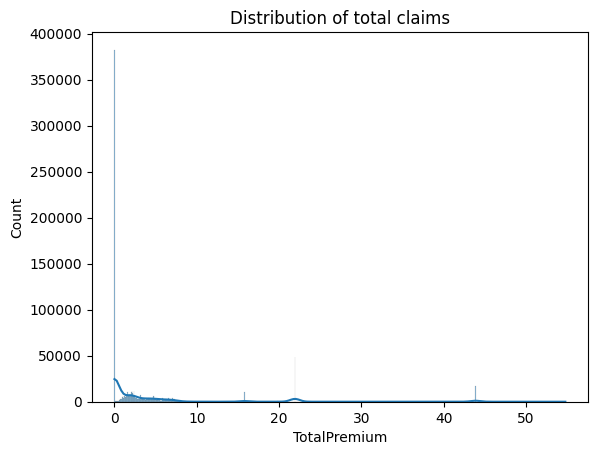

In [18]:
sns.histplot(df["TotalPremium"], kde=True)
plt.title("Distribution of total claims")
plt.show()


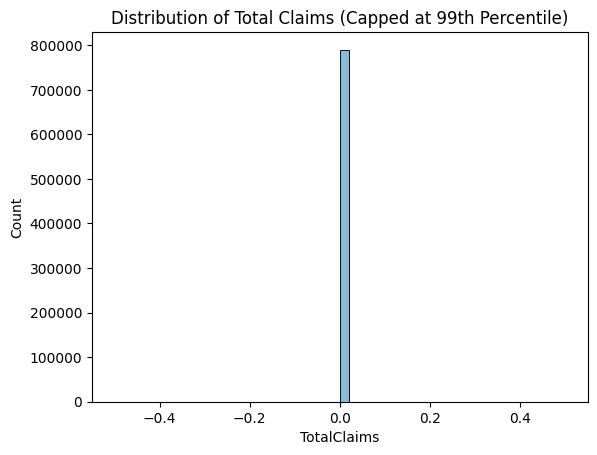

In [19]:
cap = df['TotalClaims'].quantile(0.99)
sns.histplot(df[df['TotalClaims'] <= cap]['TotalClaims'], bins=50, kde=True)
plt.title("Distribution of Total Claims (Capped at 99th Percentile)")
plt.xlabel("TotalClaims")
plt.ylabel("Count")
plt.show()

In [21]:
print(df['TotalPremium'].describe())
print(df[df['TotalPremium'] < 0])

count    1.000098e+06
mean     6.190550e+01
std      2.302845e+02
min     -7.825768e+02
25%      0.000000e+00
50%      2.178333e+00
75%      2.192982e+01
max      6.528260e+04
Name: TotalPremium, dtype: float64
        UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
82130                151624     13791  2015-02-01 00:00:00            False   
118503               151625     13791  2015-02-01 00:00:00            False   
121945               182533      7062  2015-03-01 00:00:00            False   
126228                92188      7062  2015-03-01 00:00:00            False   
134693               182534      7062  2015-03-01 00:00:00            False   
...                     ...       ...                  ...              ...   
980027                 1918       209  2014-07-01 00:00:00            False   
980053                 1895       209  2013-12-01 00:00:00            False   
980055                 1895       209  2014-03-01 00:00:00            False   

Thanks! Your results confirm the suspicion — there are 288 rows with negative TotalPremium values, which are not valid in a real insurance dataset. These could be due to:

Data entry errors

Refunds or reversals misclassified

Incorrect calculations

In [26]:
df['TotalClaims'].describe()
(df['TotalClaims'] < 0).sum()
(df['TotalClaims'] == 0).mean()

0.9972072736871787

In [27]:
df['TotalClaims'].describe()

count    1.000098e+06
mean     6.486119e+01
std      2.384075e+03
min     -1.200241e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.930921e+05
Name: TotalClaims, dtype: float64

In [28]:
(df['TotalClaims'] < 0).sum()

5

In [29]:
(df['TotalPremium'] < 0).sum()

288

In [ ]:


df['claims_zscore'] = zscore(df['TotalClaims'])
outliers_z = df[(df['claims_zscore'] > 3) | (df['claims_zscore'] < -3)]

In [32]:
outliers_z.shape

(1312, 53)